__See Preparation.ipnyb for introduction.__

In [5]:
import glob
import json
import urllib
import ntpath
import operator
import functools
import numpy as np
import pandas as pd
import osmnx as ox
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import average_precision_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel, RBF
from sklearn.neighbors import KNeighborsClassifier

%matplotlib inline

sns.set(color_codes=True)
sns.set(rc={'figure.figsize':(12.5,9.7)})

In [6]:
def add_street_prop(filename, street):
    base = ntpath.basename(filename)
    without_ext = base.split('.')[0]
    without_id = without_ext.split('__')[1]
    street_name = urllib.parse.unquote_plus(without_id)
    for x in street:
        x.update({'street': street_name})
    return street

def read_json(file):
    with open(file) as f:
        street = json.load(f)
        return add_street_prop(file, street)

def read_jsons(files):
    return [read_json(f) for f in files]

def dedupe_street(street):
    seen = set()
    return [x for x in street if [(x['street'], x['housenumber'])
                                  not in seen, seen.add((x['street'], x['housenumber']))][0]]

def get_street(blob):
    files = glob.glob(f'./data/streets/*{blob}*')
    nested = read_jsons(files)
    full = functools.reduce(operator.iconcat, nested, [])
    return dedupe_street(full)

In [7]:
landsberger_allee = get_street('Landsberger+Allee')
len(landsberger_allee)

362

In [8]:
landsberger_allee[1]

{'rowid': 349905,
 'id': 28848,
 'source': 'OA',
 'source_id': '8c5df71161e30006',
 'housenumber': 117.03,
 'lat': 52.5289723,
 'lon': 13.4563222,
 'parity': 'R',
 'proj_lat': 52.5287807927008,
 'proj_lon': 13.456427251650235,
 'marker-color': '#ff0000',
 'marker-symbol': 'o',
 'street': 'Landsberger Allee'}

In [9]:
landsberger_allee = sorted(landsberger_allee, key=lambda k: k['housenumber'])

In [10]:
def add_prev_next(street):
    for idx, x in enumerate(street):
        if idx > 0 and idx < (len(street) - 1):
            x['prev_lat'] = street[idx - 1]['proj_lat']
            x['prev_lon'] = street[idx - 1]['proj_lon']
            x['next_lat'] = street[idx + 1]['proj_lat']
            x['next_lon'] = street[idx + 1]['proj_lon']
        elif idx == 0:
            x['prev_lat'] = 0
            x['prev_lon'] = 0
            x['next_lat'] = street[idx + 1]['proj_lat']
            x['next_lon'] = street[idx + 1]['proj_lon']
        elif idx == (len(street) -1):
            x['prev_lat'] = street[idx - 1]['proj_lat']
            x['prev_lon'] = street[idx - 1]['proj_lon']
            x['next_lat'] = 0
            x['next_lon'] = 0

    return street

In [13]:
la_prev_next = add_prev_next(landsberger_allee)

In [14]:
la_prev_next[0:2]

[{'rowid': 349839,
  'id': 28846,
  'source': 'OA',
  'source_id': '6ea4d90e75cf9897',
  'housenumber': 2,
  'lat': 52.5230406,
  'lon': 13.4344582,
  'parity': 'R',
  'proj_lat': 52.523191973034486,
  'proj_lon': 13.434421937319877,
  'marker-color': '#ff0000',
  'marker-symbol': 'e',
  'street': 'Landsberger Allee',
  'prev_lat': 0,
  'prev_lon': 0,
  'next_lat': 52.52320633187243,
  'next_lon': 13.434586673049742},
 {'rowid': 349840,
  'id': 28846,
  'source': 'OA',
  'source_id': 'cd1b022bc8ef6b9a',
  'housenumber': 4,
  'lat': 52.5230755,
  'lon': 13.4346163,
  'parity': 'R',
  'proj_lat': 52.52320633187243,
  'proj_lon': 13.434586673049742,
  'marker-color': '#ff0000',
  'marker-symbol': 'e',
  'street': 'Landsberger Allee',
  'prev_lat': 52.523191973034486,
  'prev_lon': 13.434421937319877,
  'next_lat': 52.52322547410281,
  'next_lon': 13.434857931689066}]

In [15]:
def fit_knn(streets):
    features = np.array([[x['prev_lat'], x['prev_lon'], x['next_lat'], x['next_lon'], x['parity']] for x in streets])
    labels = np.array([[x['proj_lat'], x['proj_lon']] for x in streets])
    
    enc = OneHotEncoder(handle_unknown='ignore')
    enc_features = enc.fit_transform(features)
    enc_features = enc_features.toarray()

    train_feats, test_feats = train_test_split(enc_features, test_size=0.25, random_state=42)
    train_labels, test_labels = train_test_split(labels, test_size=0.25, random_state=42)

    from sklearn.neighbors import KNeighborsRegressor
    
    neigh = KNeighborsRegressor(n_neighbors=2)
    model = neigh.fit(train_feats, train_labels) 

    train_predictions = model.predict(train_feats)
    training_score = mean_squared_error(train_predictions, train_labels)

    test_predictions = model.predict(test_feats)
    test_score = mean_squared_error(test_labels, test_predictions)
    
    return (training_score, test_score)

In [16]:
_, knn_score = fit_knn(la_prev_next)
print(f'kNN Test MSE: {knn_score}')

kNN Test MSE: 0.0017756434551236548


__Notes:__

* Parity improves test MSE slightly.

#### Gaussian Process Regressor

In [17]:
def fit_gp(streets):
    features = np.array([[x['prev_lat'], x['prev_lon'], x['next_lat'], x['next_lon']] for x in streets])
    labels = np.array([[x['proj_lat'], x['proj_lon']] for x in streets])
    
    enc = OneHotEncoder(handle_unknown='ignore')
    enc_features = enc.fit_transform(features)
    enc_features = enc_features.toarray()

    train_feats, test_feats = train_test_split(enc_features, test_size=0.25, random_state=42)
    train_labels, test_labels = train_test_split(labels, test_size=0.25, random_state=42)
    
    kernel = RBF()
    gpr = GaussianProcessRegressor(kernel=kernel,
            random_state=0).fit(train_feats, train_labels)
    
    train_predictions = gpr.predict(train_feats)
    training_score = mean_squared_error(train_predictions, train_labels)
    
    test_predictions = gpr.predict(test_feats)
    test_score = mean_squared_error(test_labels, test_predictions)
    
    all_predictions = gpr.predict(enc_features)
    all_score = mean_squared_error(labels, all_predictions)
    
    return (training_score, test_score, all_score, test_predictions, test_labels, all_predictions)


In [18]:
(_, gpr_score, _, test_predictions, test_labels, all_predictions) = fit_gp(la_prev_next)
print(f'GPR Test MSE: {gpr_score}')

GPR Test MSE: 0.0011272474687725892


__Notes:__

* Parity did not make a difference in test MSE. In fact it increases it by a tiny bit.
* RBF kernel performs way better than dot product.

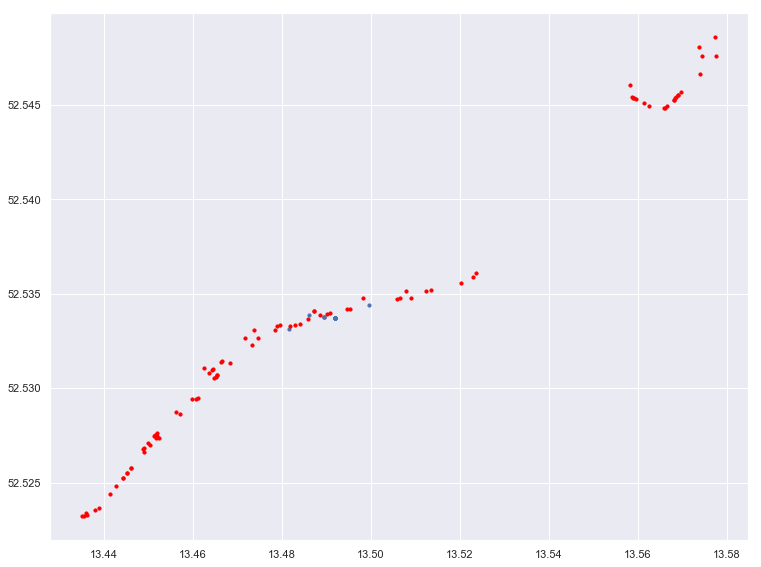

In [30]:
def plot(lon_lats_1, lon_lats_2):
    lats_1 = [x[1] for x in lon_lats_1]
    lons_1 = [x[0] for x in lon_lats_1]
    lats_2 = [x[1] for x in lon_lats_2]
    lons_2 = [x[0] for x in lon_lats_2]
    
    plt.scatter(lats_1, lons_1, s=10)
    plt.scatter(lats_2, lons_2, c='red', s=10)

plot(test_predictions, test_labels)

In [34]:
def plot_street(pred_coords, label_coords, address, distance=2000):
    pred_lons = [x[1] for x in pred_coords]
    pred_lats = [x[0] for x in pred_coords]
    label_lons = [x[1] for x in label_coords]
    label_lats = [x[0] for x in label_coords]
    G = ox.graph_from_address(address, distance=distance)
    fig, ax = ox.plot_graph(G, fig_height=10, fig_width=10, show=False, close=False, edge_color='black', node_color='none')
    ax.scatter(pred_lons, pred_lats, marker='o', s=15, c="blue")
    ax.scatter(label_lons, label_lats, marker='X', s=15, c="red")

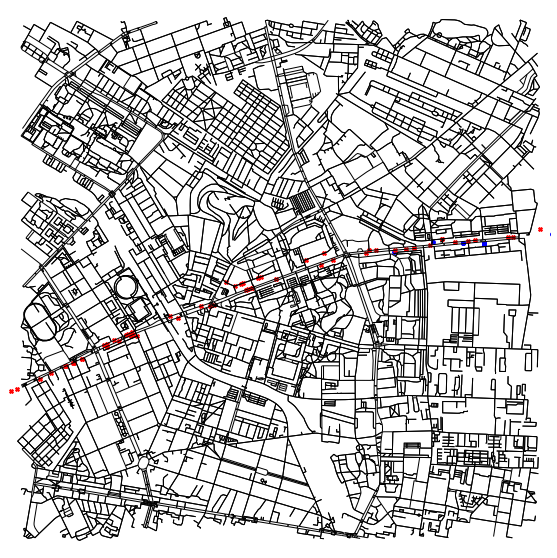

In [35]:
plot_street(test_predictions, test_labels, 'Landsberger Allee, Berlin, Germany')

### GPR on all streets

In [232]:
all_streets = get_street('')

In [ ]:
some_streets = all_streets[:20000]